# Data Science for Business

## Spring 2020, module 4 @ HSE

---

## Home assignment 2


Author: **Miron Rogovets**

---

Analyze Titanic data.

In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold

import graphviz
from sklearn import tree

In [2]:
pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))
sns.set_style('darkgrid')

In [3]:
df = pd.read_csv('data/titanic_data.csv')
print(df.shape)
df.head(3)

(1309, 12)


,Passenger Class,Name,Sex,Age,No of Siblings or Spouses on Board,No of Parents or Children on Board,Ticket Number,Passenger Fare,Cabin,Port of Embarkation,Life Boat,Survived
0,First,"Allen, Miss. Elisabeth Walton",Female,29.00,0,0,24160,211.34,B5,Southampton,2,Yes
1,First,"Allison, Master. Hudson Trevor",Male,0.92,1,2,113781,151.55,C22 C26,Southampton,11,Yes
2,First,"Allison, Miss. Helen Loraine",Female,2.00,1,2,113781,151.55,C22 C26,Southampton,NaN,No


### I. Start with basic EDA (Exploratory data analysis):
1. Compute average `Age` of passengers and number of passengers who survived and not survived grouped by `Sex` and `Passenger Class` (24 numbers);

2. What can you say about survivors based on the resulting table (open question), e.g. what is the surviving ratio for females in First class compared to the Second and Third? 
    *This answer is limited to 150 words.*


3. What is the average number of males and females on all boats (rounded to the closest integer)? 
    *Do not forget to filter out all `?` in `Life Boat` attribute.* 

In [4]:
df.groupby(['Sex', 'Passenger Class', 'Survived'])['Age'].agg(['mean', 'size'])

mean  size
Sex    Passenger Class Survived            
Female First           No       35.20     5
                       Yes      37.11   139
       Second          No       34.09    12
                       Yes      26.71    94
       Third           No       23.42   110
                       Yes      20.81   106
Male   First           No       43.66   118
                       Yes      36.17    61
       Second          No       33.09   146
                       Yes      17.45    25
       Third           No       26.68   418
                       Yes      22.44    75

- The total number of survivors is the highest in _First_ class, the lowest in _Second_ (_Third_ in the middle)
- The total number of _Male_ survivors is less than _Females_ in all classes
- About 97% _Females_ from _First_ class survived, while only about 37% _Males_
- _Males_ have surviving ratio less than 50% for all classes
- _Females_ have surviving ratio more than 50% for _First_ and _Second_ classes, and about 50% for _Third_
- The lower the class, the lower the percentage of survivors for _Females_ (as _Males_ have a bit lower percentage for _Second_ than for _Third_)
- The passengers from _First_ class are older in average than passengers from other classes
- Younger passengers have higher probability of surviving (except _Females_ from _First_ class)

In [5]:
df[~df['Life Boat'].isna()].groupby(['Life Boat', 'Sex']).agg('size').groupby('Sex').agg('mean')

Sex
Female   13.87
Male      6.96
dtype: float64

### II. Proceed with feature generation.
1. Drop the column `Life Boat`.

In [6]:
data = df.drop(columns=['Life Boat'])
data.head(2)

,Passenger Class,Name,Sex,Age,No of Siblings or Spouses on Board,No of Parents or Children on Board,Ticket Number,Passenger Fare,Cabin,Port of Embarkation,Survived
0,First,"Allen, Miss. Elisabeth Walton",Female,29.00,0,0,24160,211.34,B5,Southampton,Yes
1,First,"Allison, Master. Hudson Trevor",Male,0.92,1,2,113781,151.55,C22 C26,Southampton,Yes


2. Generate new attribute `Family size`: sum up `No of Parents or Children on Board` and `No of Siblings or Spouses on Board` and add 1 (for passenger himself). What is the average family size? In which class did the biggest family travel?
    *Do not drop original attributes.*

In [7]:
data['Family Size'] = data['No of Siblings or Spouses on Board'] + \
                      data['No of Parents or Children on Board'] + 1
data.head(2)

,Passenger Class,Name,Sex,Age,No of Siblings or Spouses on Board,No of Parents or Children on Board,Ticket Number,Passenger Fare,Cabin,Port of Embarkation,Survived,Family Size
0,First,"Allen, Miss. Elisabeth Walton",Female,29.00,0,0,24160,211.34,B5,Southampton,Yes,1
1,First,"Allison, Master. Hudson Trevor",Male,0.92,1,2,113781,151.55,C22 C26,Southampton,Yes,4


In order to find average family size we divide number of people with same sizes by family size to get the real number of families of each size. Then we simply divide total number of passenger by total number of families to get an average size.

In [8]:
family_size = data.groupby('Family Size').size()
mean = family_size.values.sum() / (family_size.values / family_size.index.values).sum()
f"Mean size = {mean:.2f}"

'Mean size = 1.33'

In [9]:
data[data['Family Size'] == data['Family Size'].max()]['Passenger Class'].unique()

array(['Third'], dtype=object)

3. It seems that `Passenger Fare` is total among all passengers with the same `Ticket Number`: create new attribute `Single passenger fare`. For every passenger you need to compute the number of passengers with the same `Ticket Number` and then use this number as a divisor for `Passenger Fare`. 
    *Do not drop the original attribute.*

In [10]:
tickets = data.groupby('Ticket Number')['Ticket Number'].transform('size')
data['Single passenger fare'] = data['Passenger Fare'] / tickets
data.head(5)

,Passenger Class,Name,Sex,Age,No of Siblings or Spouses on Board,No of Parents or Children on Board,Ticket Number,Passenger Fare,Cabin,Port of Embarkation,Survived,Family Size,Single passenger fare
0,First,"Allen, Miss. Elisabeth Walton",Female,29.00,0,0,24160,211.34,B5,Southampton,Yes,1,52.83
1,First,"Allison, Master. Hudson Trevor",Male,0.92,1,2,113781,151.55,C22 C26,Southampton,Yes,4,25.26
2,First,"Allison, Miss. Helen Loraine",Female,2.00,1,2,113781,151.55,C22 C26,Southampton,No,4,25.26
3,First,"Allison, Mr. Hudson Joshua Creighton",Male,30.00,1,2,113781,151.55,C22 C26,Southampton,No,4,25.26
4,First,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",Female,25.00,1,2,113781,151.55,C22 C26,Southampton,No,4,25.26


In [11]:
data.groupby(['Passenger Class'])['Single passenger fare'].mean().reset_index()

,Passenger Class,Single passenger fare
0,First,33.91
1,Second,11.41
2,Third,7.33


4. Impute missing values: for numerical attributes use averaging over three groups: `Passenger Class`, `Sex`, `Embarkation Port`; for every numerical attribute create separate column that contain 1 for imputed value and 0 for originally presented. 
    *This step is mainly for practicing your groupby/join skills. In real tasks this kind of imputation is relatively rare.*

In [12]:
numeric = data.select_dtypes(include=np.number).columns
numeric

Index(['Age', 'No of Siblings or Spouses on Board',
       'No of Parents or Children on Board', 'Passenger Fare', 'Family Size',
       'Single passenger fare'],
      dtype='object')

In [13]:
data[numeric].isna().sum()

Age                                   263
No of Siblings or Spouses on Board      0
No of Parents or Children on Board      0
Passenger Fare                          1
Family Size                             0
Single passenger fare                   1
dtype: int64

In [14]:
data.shape

(1309, 13)

In [15]:
for col in numeric:
    if data[col].isna().any():
        data[col + ' imputed'] = data[col].isna().astype(int)
        data[col] = data[col].fillna(data.groupby(['Sex', 'Passenger Class', 'Port of Embarkation'])
                                     [col].transform('mean'))
data[numeric].isna().sum()

Age                                   0
No of Siblings or Spouses on Board    0
No of Parents or Children on Board    0
Passenger Fare                        0
Family Size                           0
Single passenger fare                 0
dtype: int64

In [16]:
data.shape

(1309, 16)

5. Pre-process categorical attributes: For every categorical attribute create a separate column that contains 1 for a missing value and 0 for originally presented. One-hot encode categorical attributes with less than 20 unique values, drop other categorical attributes; drop original attributes.

In [17]:
categorical = data.select_dtypes(include=['object']).columns
categorical

Index(['Passenger Class', 'Name', 'Sex', 'Ticket Number', 'Cabin',
       'Port of Embarkation', 'Survived'],
      dtype='object')

In [18]:
data[categorical].isna().sum()

Passenger Class           0
Name                      0
Sex                       0
Ticket Number             0
Cabin                  1014
Port of Embarkation       2
Survived                  0
dtype: int64

In [20]:
for col in categorical:
    if data[col].isna().any():
        data[col + ' missing'] = data[col].isna().astype(int)

In [21]:
to_drop = categorical[data[categorical].nunique() >= 20]
to_drop

Index(['Name', 'Ticket Number', 'Cabin'], dtype='object')

In [22]:
data = data.drop(columns=to_drop)
data.head(3)

,Passenger Class,Sex,Age,No of Siblings or Spouses on Board,No of Parents or Children on Board,Passenger Fare,Port of Embarkation,Survived,Family Size,Single passenger fare,Age imputed,Passenger Fare imputed,Single passenger fare imputed,Cabin missing,Port of Embarkation missing
0,First,Female,29.00,0,0,211.34,Southampton,Yes,1,52.83,0,0,0,0,0
1,First,Male,0.92,1,2,151.55,Southampton,Yes,4,25.26,0,0,0,0,0
2,First,Female,2.00,1,2,151.55,Southampton,No,4,25.26,0,0,0,0,0


In [23]:
data = pd.get_dummies(data, prefix=categorical.drop(to_drop), 
                      columns=categorical.drop(to_drop), drop_first=True)
data.head(3)

,Age,No of Siblings or Spouses on Board,No of Parents or Children on Board,Passenger Fare,Family Size,Single passenger fare,Age imputed,Passenger Fare imputed,Single passenger fare imputed,Cabin missing,Port of Embarkation missing,Passenger Class_Second,Passenger Class_Third,Sex_Male,Port of Embarkation_Queenstown,Port of Embarkation_Southampton,Survived_Yes
0,29.00,0,0,211.34,1,52.83,0,0,0,0,0,0,0,0,0,1,1
1,0.92,1,2,151.55,4,25.26,0,0,0,0,0,0,0,1,0,1,1
2,2.00,1,2,151.55,4,25.26,0,0,0,0,0,0,0,0,0,1,0


In [24]:
data.isna().sum()

Age                                   0
No of Siblings or Spouses on Board    0
No of Parents or Children on Board    0
Passenger Fare                        0
Family Size                           0
Single passenger fare                 0
Age imputed                           0
Passenger Fare imputed                0
Single passenger fare imputed         0
Cabin missing                         0
Port of Embarkation missing           0
Passenger Class_Second                0
Passenger Class_Third                 0
Sex_Male                              0
Port of Embarkation_Queenstown        0
Port of Embarkation_Southampton       0
Survived_Yes                          0
dtype: int64

In [25]:
data.shape

(1309, 17)

6. Set the role of the `Survived` attribute to `label`.

In [26]:
data = data.rename(columns={'Sex_Male': 'Sex', 'Survived_Yes': 'Survived'})
data.head(3)

,Age,No of Siblings or Spouses on Board,No of Parents or Children on Board,Passenger Fare,Family Size,Single passenger fare,Age imputed,Passenger Fare imputed,Single passenger fare imputed,Cabin missing,Port of Embarkation missing,Passenger Class_Second,Passenger Class_Third,Sex,Port of Embarkation_Queenstown,Port of Embarkation_Southampton,Survived
0,29.00,0,0,211.34,1,52.83,0,0,0,0,0,0,0,0,0,1,1
1,0.92,1,2,151.55,4,25.26,0,0,0,0,0,0,0,1,0,1,1
2,2.00,1,2,151.55,4,25.26,0,0,0,0,0,0,0,0,0,1,0


### III. Finish by building a classification model using preprocessed data
1. Compute classification accuracy on a train-test setup:
    - Create a Cross Validation block, fix the random_state parameter to 2020.
    - Use a decision tree with `maximal depth` = 7; uncheck `apply pruning` box; leave all other parameters by default.
    - Use accuracy as a performance metric



In [27]:
X = data.drop(columns=['Survived'])
y = data.Survived

In [142]:
kf = KFold(n_splits=5, shuffle=True, random_state=2020)

In [156]:
scores = []
model = DecisionTreeClassifier(max_depth=7)
for train, test in kf.split(X):
    X_train, X_test, y_train, y_test = X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))
print(f'{np.mean(scores):.2f}')
print(f'{np.std(scores):.2f}')

0.79
0.02


In [157]:
scores

[0.7519083969465649,
 0.7824427480916031,
 0.8282442748091603,
 0.7938931297709924,
 0.7816091954022989]

2. Analyze the resulting confusion matrix, which error is larger: Type I or Type II? 

In [163]:
predicted = model.predict(X)
cm = confusion_matrix(y, predicted)

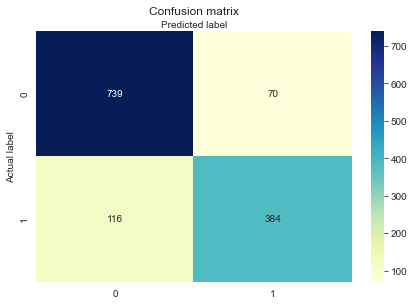

In [165]:
names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(names))
plt.xticks(tick_marks, names)
plt.yticks(tick_marks, names)
sns.heatmap(cm, annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

Type I is larger than Type II

3. Provide a short analysis of the results, based on your answers III.2-III.3. E.g. What are the splitting features of the first 3 levels of the best tree (up to 7 attributes)? Do these results coincide with your intuition? You may include some misclassified examples along with explanations why they were misclassified. 
    *This answer is limited to 250 words.*

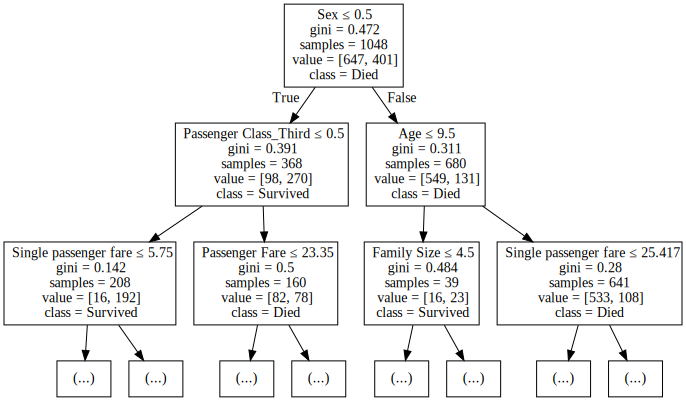

In [177]:
graph = graphviz.Source(
    tree.export_graphviz(
        model,
        max_depth=2,
        feature_names=X.columns,
        class_names=['Died', 'Survived'],
        special_characters=True))
graph

- Sex is the first layer split feature: males have less propability of survival (which is logical as most of them will help women first)
- Age and Third Class are features of second level. Passengers from the third class have less chances to survive (as they probably have a longer way to get to the life boats). Also, young passengers have higher chances which can be stated as children are saved first
- The third level features are passenger fare, single passenger fare, which are highly correlated, and family size. Larger families have less probability of survival (as there are too many siblings to try to save)